# Inference: Slice Sampling with Hyperrectangles
This example shows you how to perform Bayesian inference on multiple toy problems, using
Slice Sampling with Hyperrectangles, as described in [1].

This is a multivariate method, which generates n-dimensional samples of the form $x = (x_1, ..., x_n)$ by sampling uniformly from the area of an axis-aligned hyperrectangle: $H = \{x: L_i < x_i < R_i$ for all $i = 1, ..., n\}$. Here, $L_i$ and $R_i$ define the extent of the hyperrectangle along the $i$th axis.

Sampling follows:

1. Calculate the pdf ($f(x0)$) of the current sample ($x_0$).
2. Draw a real value ($y$) uniformly from $(0, f(x_0))$, defining a
   horizontal “slice”: $S = {x: y < f (x)}$. Note that $x_0$ is
   always within $S$.
3. Find a hyperrectangle ($H = (L_1, R_1) ×···× (L_n, R_n)$) around
   $x_0$, which preferably contains at least a big part of the slice.
4. Draw a new point ($x_1$) from the part of the slice within this
   hyperrectangle.

The implementation uses estimates (``width``) of the relative scales of the variables to randomly position a hyperrectangle with such dimensions uniformly over positions containing $x_0$ that lead to $H$.

When a sample is rejected, the algorithm shrinks the hyperrectangle homogeneously in all directions.
    
[1] Neal, R.M., 2003. Slice sampling. The annals of statistics, 31(3),
    pp.705-767.

# Problem 1: Unimodal Gaussian Distribution
First, we create our target Gaussian distribution.

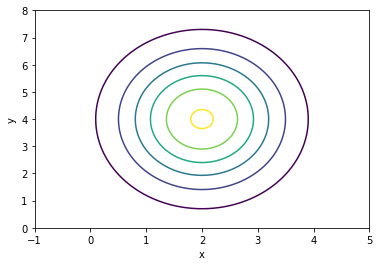

In [2]:
import os
os.chdir("../")
import pints
import pints.toy
import numpy as np
import matplotlib.pyplot as plt

# Create log pdf
log_pdf = pints.toy.GaussianLogPDF([2, 4], [[1, 0], [0, 3]])

# Contour plot of pdf
levels = np.linspace(-3,12,20)
num_points = 100
x = np.linspace(-1, 5, num_points)
y = np.linspace(-0, 8, num_points)
X, Y = np.meshgrid(x, y)
Z = np.zeros(X.shape)
Z = np.exp([[log_pdf([i, j]) for i in x] for j in y])
plt.contour(X, Y, Z)
plt.xlabel('x')
plt.ylabel('y')
plt.show()

Now we set up a sampling routine using Slice Sampling with Hyperrectangles.

In [3]:
# Choose starting point for 3 mcmc chains
xs = [
    [2, 4],
    [3, 3],
    [5, 4],
]

# Create mcmc routine
mcmc = pints.MCMCController(log_pdf, 3, xs, method=pints.SliceHyperrectanglesMCMC)

# Add stopping criterion
mcmc.set_max_iterations(2000)

# Set up modest logging
mcmc.set_log_to_screen(True)
mcmc.set_log_interval(1000)

We now set the hyperparameters of the sampler:

1. The estimates ``width`` of the relative scales of the variables.

These are going to be the dimesions of the hyperrectangle $H$. Preferably, $H$ should contain most of the slice. In this example, we set ``width = [8, 8]``.

In [4]:
for sampler in mcmc.samplers():
    sampler.set_width(8)
    
# Run!
print('Running...')
full_chains = mcmc.run()
print('Done!')

Running...
Using Slice Sampling - Hyperrectangles
Generating 3 chains.
Running in sequential mode.
Iter. Eval. Time m:s
0     3       0:00.0
1     12      0:00.0
2     18      0:00.0
3     30      0:00.0
1000  8991    0:00.6
2000  17843   0:01.1
Halting: Maximum number of iterations (2000) reached.
Done!


This method is much faster than other Slice Sampling methods on low-dimensional spaces!

We then use Pints' [diagnostic plots](http://pints.readthedocs.io/en/latest/diagnostic_plots.html) to investigate the performance of the sampler.

We start by using the [trace](http://pints.readthedocs.io/en/latest/diagnostic_plots.html#pints.plot.trace) to see if the 3 chains have converged to the same solution.

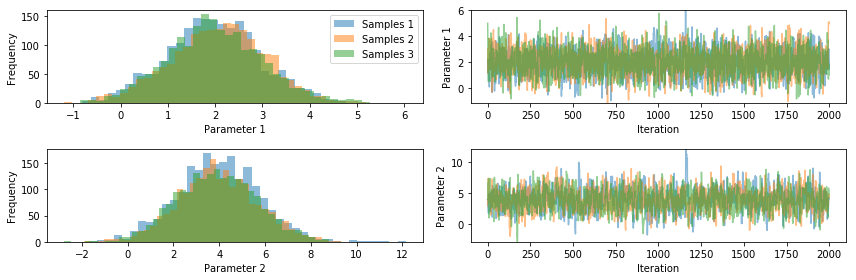

In [5]:
# Show traces and histograms
import pints.plot
pints.plot.trace(full_chains)
plt.show()

Based on this plot, it looks like the three chains become very similar after only a few iterations, and preserve a similar behaviour for the remaining iterations. To further investigate convergence, we can use the R-hat criterion, which is based on the stability of outcomes between and within chains of the same length. If everything went well, we should expect values close to 1.

In [6]:
# Check convergence using rhat criterion
print('R-hat:')
print(pints.rhat_all_params(full_chains))

R-hat:
[1.0010606734887204, 1.0002213241806097]


As we can see, the chains converge to the same underlying distribution!

We can now continue our analysis by considering the [autocorrelation()](http://pints.readthedocs.io/en/latest/diagnostic_plots.html#pints.plot.autocorrelation) method for the first chain.

In [7]:
chain = full_chains[0]

If everything went well, the samples in the chain should be relatively independent, so the autocorrelation should get quite low when the `lag` on the x-axis increases.

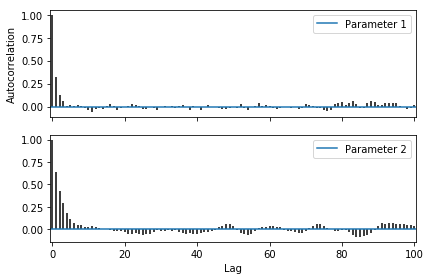

In [8]:
pints.plot.autocorrelation(chain)
plt.show()

We can now look at the correlation between the different parameters by using the [pairwise()](http://pints.readthedocs.io/en/latest/diagnostic_plots.html#pints.plot.pairwise) plot.

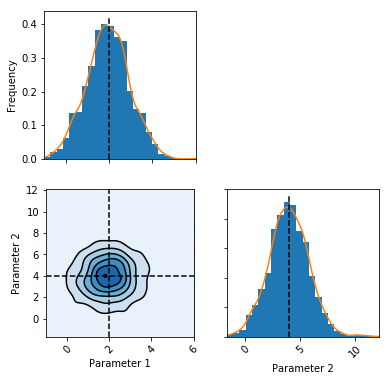

In [9]:
pints.plot.pairwise(chain, kde=True, ref_parameters=[2,4])
plt.show()

From the plots, we can see that we reach the original "true" values of the target posterior, and that the method suggests a normal distribution around the correct mean!

Finally, as our target distribution is Gaussian, we can calculate analytically the KL divergence between the distributions obtained from the chains and the true posterior distribution. We would expect the KL values to be be approximately $0$ to indicate no loss of information between the distributions.

In [10]:
# Check Kullback-Leibler divergence of chains
print(log_pdf.kl_divergence(full_chains[0]))
print(log_pdf.kl_divergence(full_chains[1]))
print(log_pdf.kl_divergence(full_chains[2]))

0.0038054358249413056
0.003370973201234584
0.003717939293792716


# Problem 2: Multimodal Distribution

Having the confidence that Slice Sampling with Hyperrectangles performs well on a simple unimodal Gaussian distribution (when the dimensios of $H$ are good indications of the dimensions of the target un-normalised distribution), we check its performance on a more problematic multimodal exercise.

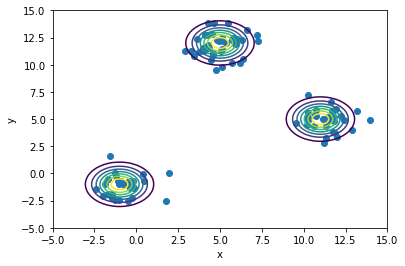

In [11]:
log_pdf = pints.toy.MultimodalGaussianLogPDF(modes=[[-1, -1], [11, 5], [5, 12]])

samples = log_pdf.sample(100)

# Contour plot of pdf
levels = np.linspace(-3,12,20)
num_points = 100
x = np.linspace(-5, 15, num_points)
y = np.linspace(-5, 15, num_points)
X, Y = np.meshgrid(x, y)
Z = np.zeros(X.shape)
Z = np.exp([[log_pdf([i, j]) for i in x] for j in y])
plt.contour(X, Y, Z)
plt.scatter(samples[:,0], samples[:,1])
plt.xlabel('x')
plt.ylabel('y')
plt.show()

If the dimensions of the hyperrectangle are big enough, we would expect the method to explore properly all the modes of the distribution.

In [12]:
# Create an adaptive covariance MCMC routine
x0 = np.random.uniform([2, 2], [8, 8], size=(4, 2))
mcmc = pints.MCMCController(log_pdf, 4, x0, method=pints.SliceHyperrectanglesMCMC)

for sampler in mcmc.samplers():
    sampler.set_width(10)
    
# Set maximum number of iterations
mcmc.set_max_iterations(2000)

# Disable logging
mcmc.set_log_to_screen(False)

# Number of chains
num_chains = 4

# Run!
print('Running...')
chains = mcmc.run()
print('Done!')

Running...
Done!


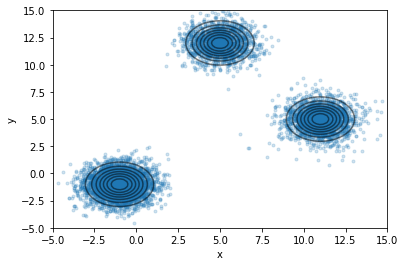

In [13]:
stacked = np.vstack(chains)
plt.contour(X, Y, Z, colors='k', alpha=0.5)
plt.scatter(stacked[:,0], stacked[:,1], marker='.', alpha=0.2)
plt.xlim(-5, 15)
plt.ylim(-5, 15)
plt.xlabel('x')
plt.ylabel('y')
plt.show()

As expected, using a hyperrectangle with ``width`` = $10$, we explore efficiently the parameter space, capturing all the modes of the target distributio.

The KL divergence should be very good for the three modes.

In [14]:
print("KL divergence by mode: " + str(log_pdf.kl_divergence(stacked)))

KL divergence by mode: [0.00084543 0.00565936 0.000754  ]


However, when the dimensions of the hyperrectangles are too small (``width`` = $3$), we risk not exploring one or more modes.

In [16]:
# Create an adaptive covariance MCMC routine
x0 = np.random.uniform([2, 2], [8, 8], size=(4, 2))
mcmc = pints.MCMCController(log_pdf, 4, x0, method=pints.SliceHyperrectanglesMCMC)

for sampler in mcmc.samplers():
    sampler.set_width(3)
    
# Set maximum number of iterations
mcmc.set_max_iterations(2000)

# Disable logging
mcmc.set_log_to_screen(False)

# Number of chains
num_chains = 4

# Run!
print('Running...')
chains = mcmc.run()
print('Done!')

Running...
Done!


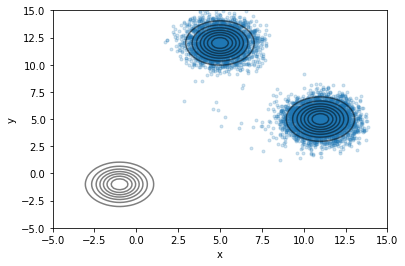

In [17]:
stacked = np.vstack(chains)
plt.contour(X, Y, Z, colors='k', alpha=0.5)
plt.scatter(stacked[:,0], stacked[:,1], marker='.', alpha=0.2)
plt.xlim(-5, 15)
plt.ylim(-5, 15)
plt.xlabel('x')
plt.ylabel('y')
plt.show()

As expected, one of the modes has hardly been explored.

The KL divergence should be very good for two modes, and obviously terrible for the non-explored one.

In [18]:
print("KL divergence by mode: " + str(log_pdf.kl_divergence(stacked)))

KL divergence by mode: [9.37409072e+01 2.15311069e-03 3.07014080e-03]


# Problem 3: Time-Series Problem - Logistic Model
We now try the same method on a more realistic time-series problem using a logistic model, following the tutorial notebook: [sampling-first-example](./sampling-first-example.ipynb).

Note that we haven't set ``width`` to any specific value. We are therefore using the default settings of the sampler, which generates estimates using the initial samples in the chains.

In [19]:
import pints
import pints.toy as toy
import pints.plot
import numpy as np
import matplotlib.pyplot as plt

# Load a forward model
model = toy.LogisticModel()

# Create some toy data
real_parameters = [0.015, 500]
times = np.linspace(0, 1000, 1000)
org_values = model.simulate(real_parameters, times)

# Add noise
noise = 10
values = org_values + np.random.normal(0, noise, org_values.shape)
real_parameters = np.array(real_parameters + [noise])

# Get properties of the noise sample
noise_sample_mean = np.mean(values - org_values)
noise_sample_std = np.std(values - org_values)

# Create an object with links to the model and time series
problem = pints.SingleOutputProblem(model, times, values)

# Create a log-likelihood function (adds an extra parameter!)
log_likelihood = pints.GaussianLogLikelihood(problem)

# Create a uniform prior over both the parameters and the new noise variable
log_prior = pints.UniformLogPrior(
    [0.01, 400, noise * 0.1],
    [0.02, 600, noise * 100],
)

# Create a posterior log-likelihood (log(likelihood * prior))
log_posterior = pints.LogPosterior(log_likelihood, log_prior)

# Choose starting points for 3 mcmc chains
num_chains = 3
xs = [
    real_parameters * 1.1,
    real_parameters * 0.9,
    real_parameters * 1.15,
]

# Create mcmc routine
mcmc = pints.MCMCController(
    log_posterior, num_chains, xs, method=pints.SliceHyperrectanglesMCMC)
    
# Add stopping criterion
mcmc.set_max_iterations(2000)

# Set up modest logging
mcmc.set_log_to_screen(True)
mcmc.set_log_interval(500)

# Run!
print('Running...')
full_chains = mcmc.run()
print('Done!')

Running...
Using Slice Sampling - Hyperrectangles
Generating 3 chains.
Running in sequential mode.
Iter. Eval. Time m:s
0     3       0:00.0
1     27      0:00.0
2     42      0:00.0
3     51      0:00.0
500   13026   0:02.7
1000  26994   0:05.5
1500  40431   0:08.0
2000  52256   0:10.3
Halting: Maximum number of iterations (2000) reached.
Done!


As done for the previous unimodal Gaussian example, we use Pints' trace tool to check convergence.

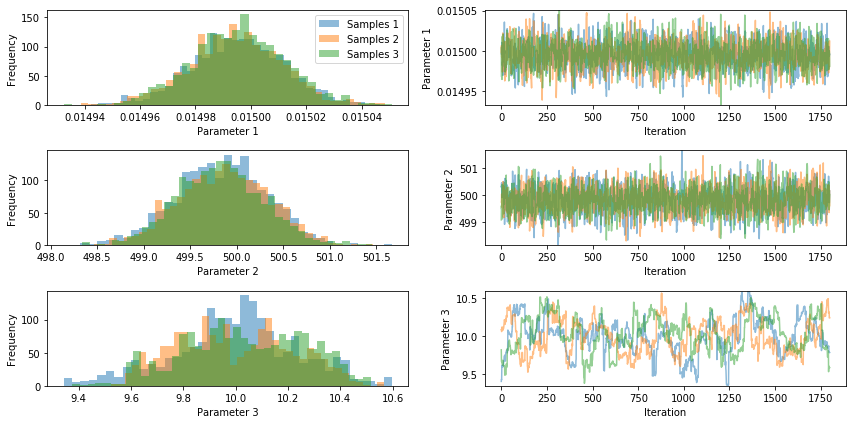

In [24]:
# Show traces and histograms
pints.plot.trace(full_chains)
plt.show()

From the plots we can see that the chains rapidly converge towards the same values after a few iterations.

To further investigate convergence, we use the R-hat criterion.

In [25]:
# Discard warm up
full_chains = full_chains[:, 200:, :]

# Check convergence using rhat criterion
print('R-hat:')
print(pints.rhat_all_params(full_chains))

R-hat:
[1.0006789846961717, 1.0011109041038977, 1.009118887883556]


Finally, we look at the correlation between different parameters.

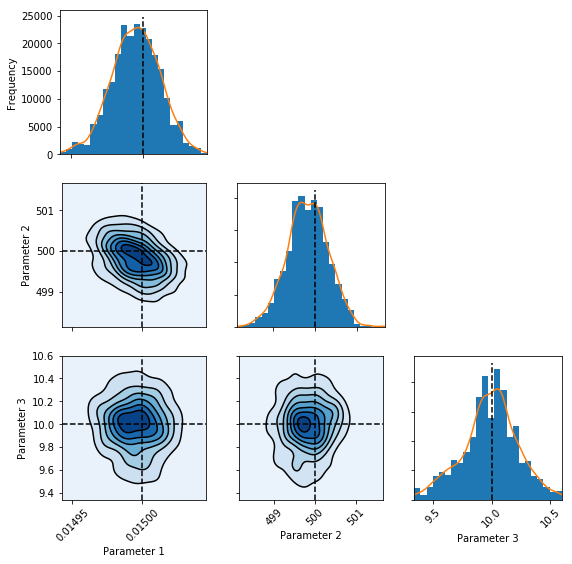

In [26]:
# Look at distribution in chain 0
pints.plot.pairwise(full_chains[0], kde=True, ref_parameters = real_parameters)

# Show graphs
plt.show()

From the plots, we see that we come close to the "true values" of the target distribution, displaying a normal distribution around such values.

# Problem 4: Rosenbrock Toy Distribution
This function (further described [here](http://pints.readthedocs.io/en/latest/toy/rosenbrock.html)) which can be used to define a normalisable probability density function:

$ p(x, y) \propto  \frac{1}{1 + \text{RosenbrockError}(x,y)}, $

that is,

$ p(x, y) \propto  \frac{1}{\left(1 + (1 - x)^2 + 100 (y - x^2)^2) \right)}, $

which we term the `RosenbrockLogPDF`.

We now plot this function.

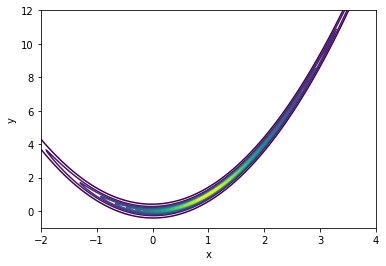

In [57]:
from __future__ import print_function
import pints
import pints.toy
import numpy as np
import matplotlib.pyplot as plt
import pints.plot

# Create Rosenbrock log pdf
log_pdf = pints.toy.RosenbrockLogPDF()

# Contour plot of pdf
levels = np.linspace(0, 1, 20)
x = np.linspace(-2, 4, 400)
y = np.linspace(-1, 12, 400)
X, Y = np.meshgrid(x, y)
Z = np.exp([[log_pdf([i, j]) for i in x] for j in y])
plt.contour(X, Y, Z, levels = levels)
plt.xlabel('x')
plt.ylabel('y')
plt.show()

We turn the problem into a Bayesian problem by using the inverse Rosenbrock function as a likelihood.

In [60]:
# Create an adaptive covariance MCMC routine
x0 = np.random.uniform([1, 1], [1.1, 1.1], size=(4, 2))
sigma0 = [0.5, 0.5]

# Use suggested prior bounds
bounds = log_pdf.suggested_bounds()

# Create a uniform prior over both the parameters
log_prior = pints.UniformLogPrior(
    bounds[0], bounds[1]
)

# Create a posterior log-likelihood (log(likelihood * prior))
log_posterior = pints.LogPosterior(log_pdf, log_prior)

mcmc = pints.MCMCController(log_posterior, 4, x0, method=pints.SliceHyperrectanglesMCMC, sigma0=sigma0)

for sampler in mcmc.samplers():
    sampler.set_width(12)
    
# Stop after 4000 iterations
mcmc.set_max_iterations(2000)

# Disable logging
mcmc.set_log_to_screen(False)

# Run!
print('Running...')
chains = mcmc.run()
print('Done!')

# Discard warm-up
chains = [chain[1000:] for chain in chains]

print('R-hat:')
print(pints.rhat_all_params(chains))

Running...
Done!
R-hat:
[1.0098572360507991, 1.0041848429980391]


The R-hat tool gives us good results, indicating that the chains converge to the same underlying distribution.

We inspect the results by creating a scatter plot of the samples.

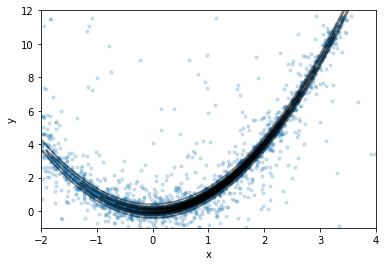

In [61]:
stacked = np.vstack(chains)
plt.contour(X, Y, Z, levels=levels, colors='k', alpha=0.5)
plt.scatter(stacked[:,0], stacked[:,1], marker='.', alpha=0.2)
plt.xlim(-2, 4)
plt.ylim(-1, 12)
plt.xlabel('x')
plt.ylabel('y')
plt.show()